In [1]:
from tscode.utils import read_xyz, graphize, scramble_check, write_xyz
import os

os.chdir('/mnt/c/Users/Nick/Desktop/winscp_temp')

mol1 = read_xyz('MsNO2.xyz')
mol2 = read_xyz('propip.xyz')
mol3 = read_xyz('maybe_scrambled.xyz')
print(len(mol1.atomcoords[0]), len(mol2.atomcoords[0]),len(mol3.atomcoords[0]))

38 116 154


In [2]:
graph1 = graphize(mol1.atomcoords[0], mol1.atomnos)
graph2 = graphize(mol2.atomcoords[0], mol2.atomnos)
graph3 = graphize(mol3.atomcoords[0], mol3.atomnos)
print(len(graph1.nodes), len(graph2.nodes),len(graph3.nodes))

38 116 154


In [3]:
import numpy as np

In [4]:
mols_graphs = [graph1, graph2]
constrained_indices = np.array([
    [4, 35],
    [36, 153], [37, 149]])
excluded_atoms = constrained_indices.ravel()
excluded_atoms

array([  4,  35,  36, 153,  37, 149])

In [5]:
from tscode.calculators._xtb import xtb_opt
opt_coords, energy, success = xtb_opt(
                mol3.atomcoords[0],
                # opt_coords,
                mol3.atomnos,
                # constrained_indices=constrained_indices,
                # constrained_distances=[None, 1.6, 1.6],
                constrained_indices=[constrained_indices[0]],
                constrained_distances=[None,],
                method='GFN2-XTB')
success

True

In [6]:
energy

-162656.01207416796

In [7]:
bonds = set()
for i, graph in enumerate(mols_graphs):

    # pos = 0
    # while i != 0:
    #     pos += len(mols_graphs[i-1].nodes)
    #     i -= 1
    pos = sum([len(other_graph.nodes) for j, other_graph in enumerate(mols_graphs) if j < i])

    for bond in [tuple(sorted((a+pos, b+pos))) for a, b in list(graph.edges) if a != b]:
        bonds.add(bond)
# creating bond set containing all bonds present in the desired transition state

new_bonds = {tuple(sorted((a, b))) for a, b in list(graphize(opt_coords, mol3.atomnos).edges) if a != b}
delta_bonds = (bonds | new_bonds) - (bonds & new_bonds)
# delta_bonds -= {tuple(sorted(pair)) for pair in constrained_indices}

for bond in delta_bonds.copy():
    for a in excluded_atoms:
        if a in bond:
            delta_bonds -= {bond}
# removing bonds involving constrained atoms: they are not counted as scrambled bonds


In [8]:
delta_bonds

set()

In [9]:
with open('optimized.xyz', 'w') as _f:
    write_xyz(opt_coords, mol3.atomnos, _f)

In [3]:
with open('force_field_refining_tight_constraints.dat', 'r') as f:
    data = f.read()

In [4]:
lines = [line.split(' : ')[1] for line in data.replace('\n [', ', [').split('\n') if len(line.split(' : ')) > 1]

In [5]:
lines = [line.replace('[','').replace(',', '').replace(']','').split() for line in lines]

In [6]:
lines = [[int(n) for n in line] for line in lines]

In [7]:
ens_constr = np.array([[[l[0], l[1]], [l[2], l[3]]] for l in lines])
ens_constr[0]

array([[ 36, 153],
       [ 37, 149]])

In [8]:
ens_structs = read_xyz('force_field_refining_tight_structures.xyz')
print(len(ens_structs.atomcoords), len(ens_constr))

3073 3073


(array([521., 287., 434., 393., 256., 189., 360., 321., 241.,  71.]),
 array([-0.13143273,  1.72435417,  3.58014108,  5.43592798,  7.29171489,
         9.14750179, 11.0032887 , 12.8590756 , 14.71486251, 16.57064941,
        18.42643632]),
 <BarContainer object of 10 artists>)

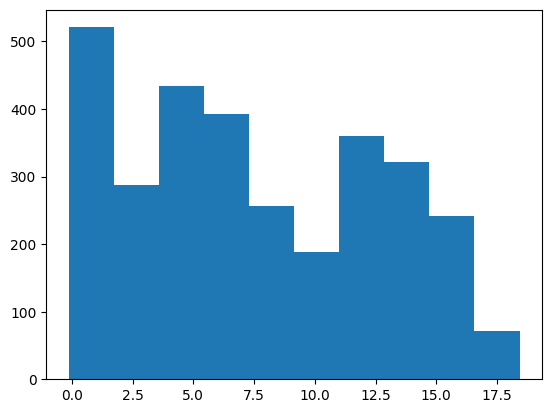

In [11]:
from tscode.utils import norm_of
import matplotlib.pyplot as plt
errors = []
for constraint, structure in zip(ens_constr, ens_structs.atomcoords):
    (a, b), (c, d) = constraint
    d1 = norm_of(
        structure[a]-
        structure[b]
    ) - 1.6
    d2 = norm_of(
        structure[c]-
        structure[d]
    ) - 1.6
    errors.append(d1+d2)
plt.hist(errors)

## LOADING EMBEDDER

In [4]:
os.chdir('multiembed_test')

In [9]:
import pickle

with open('force_field_refining_tight_runembedding.pickle', 'rb') as f:
    d = pickle.load(f)

## LOW MEMORY SIMILARITY PRUNING

In [2]:
from tscode.python_functions import rmsd_and_max
import numpy as np
from tscode.utils import read_xyz
import networkx as nx

In [3]:
from memory_profiler import profile

# @profile
def prune_conformers_rmsd(structures, atomnos, max_rmsd=0.25, max_delta=None, verbose=False):
    '''
    Removes similar structures by repeatedly grouping them into k
    subgroups and removing similar ones. A cache is present to avoid
    repeating RMSD computations.
    
    Similarity occurs for structures with both RMSD < max_rmsd and
    maximum deviation < max_delta.
    '''

    max_delta = (max_rmsd * 2) if max_delta is None else max_delta

    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])

    cache_set = set()
    final_mask = np.ones(structures.shape[0], dtype=bool)
    
    for k in (5e5, 2e5, 1e5, 5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50, 20, 10, 5, 2, 1):

        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            if verbose:      
                print(f'Working on subgroups with k={k} ({num_active_str} candidates left) {" "*10}', end='\r')

            d = int(len(structures) // k)

            for step in range(int(k)):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    _l = len(range(d*step, num_active_str))
                else:
                    _l = len(range(d*step, int(d*(step+1))))

                similarity_mat = np.zeros((_l, _l))

                for i_rel in range(_l):
                    for j_rel in range(i_rel+1,_l):

                        i_abs = i_rel+(d*step)
                        j_abs = j_rel+(d*step)

                        if (i_abs, j_abs) not in cache_set:
                        # if we have already performed the comparison,
                        # structures were not similar and we can skip them

                            rmsd, max_dev = rmsd_and_max(heavy_structures[i_abs],
                                                         heavy_structures[j_abs])

                            if rmsd < max_rmsd and max_dev < max_delta:
                                similarity_mat[i_rel,j_rel] = 1
                                break

                for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
                    i_abs = i_rel+(d*step)
                    j_abs = j_rel+(d*step)
                    cache_set.add((i_abs, j_abs))
                    # adding indices of structures that are considered equal,
                    # so as not to repeat computing their RMSD
                    # Their index accounts for their position in the initial
                    # array (absolute index)

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [group[0] for group in groups]
                # of each cluster, keep the first structure

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0

    return structures[final_mask], final_mask

# @profile
def lowmem_prune_conformers_rmsd(structures, atomnos, max_rmsd=0.25, max_delta=None, verbose=False):
    '''
    Removes similar structures by repeatedly grouping them into k
    subgroups and removing similar ones. A cache is present to avoid
    repeating RMSD computations.
    
    Similarity occurs for structures with both RMSD < max_rmsd and
    maximum deviation < max_delta.
    '''

    max_delta = (max_rmsd * 2) if max_delta is None else max_delta

    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])

    cache_set = set()
    final_mask = np.ones(structures.shape[0], dtype=bool)
    
    for k in (5e5, 2e5, 1e5, 5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50, 20, 10, 5, 2, 1):

        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            if verbose:      
                print(f'Working on subgroups with k={k} ({num_active_str} candidates left) {" "*10}', end='\r')

            d = int(len(structures) // k)

            for step in range(int(k)):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    _l = len(range(d*step, num_active_str))
                else:
                    _l = len(range(d*step, int(d*(step+1))))

                # similarity_mat = np.zeros((_l, _l))
                matches = set()

                for i_rel in range(_l):
                    for j_rel in range(i_rel+1,_l):

                        i_abs = i_rel+(d*step)
                        j_abs = j_rel+(d*step)

                        if (i_abs, j_abs) not in cache_set:
                        # if we have already performed the comparison,
                        # structures were not similar and we can skip them

                            rmsd, max_dev = rmsd_and_max(heavy_structures[i_abs],
                                                         heavy_structures[j_abs])

                            if rmsd < max_rmsd and max_dev < max_delta:
                                # similarity_mat[i_rel,j_rel] = 1
                                matches.add((i_rel, j_rel))
                                break

                            else:
                                i_abs = i_rel+(d*step)
                                j_abs = j_rel+(d*step)
                                cache_set.add((i_abs, j_abs))
                # for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
                    # i_abs = i_rel+(d*step)
                    # j_abs = j_rel+(d*step)
                    # cache_set.add((i_abs, j_abs))
                    # adding indices of structures that are considered equal,
                    # so as not to repeat computing their RMSD
                    # Their index accounts for their position in the initial
                    # array (absolute index)

                # matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [group[0] for group in groups]
                # of each cluster, keep the first structure

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0

    return structures[final_mask], final_mask


In [4]:
data = read_xyz('/mnt/c/Users/Nick/Desktop/Computations/debug/restart.xyz')
data.atomcoords.shape

(100, 154, 3)

In [39]:
_, mask1 = prune_conformers_rmsd(data.atomcoords, data.atomnos, 1.5)
_, mask2 = lowmem_prune_conformers_rmsd(data.atomcoords, data.atomnos, 1.5)
np.all(mask1 == mask2)

False

In [49]:
%%timeit
_, mask1 = prune_conformers_rmsd(data.atomcoords, data.atomnos, 0.25)

UsageError: Cell magic `%%memit` not found.


In [48]:
%%timeit
_, mask2 = lowmem_prune_conformers_rmsd(data.atomcoords, data.atomnos, 0.25)

213 ms ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
np.where(mask1 != mask2)

(array([ 9, 36, 47, 49, 52]),)

In [23]:
np.count_nonzero(mask1 != mask2)

5

In [33]:
similarity_mat = np.zeros((3,3))
similarity_mat[0,0] = 1
similarity_mat[1,1] = 1
for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
    print(i_rel, j_rel)
similarity_mat

0 1
0 2
1 0
1 2
2 0
2 1
2 2


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [10]:
%load_ext memory_profiler

In [8]:
structs = np.concatenate([data.atomcoords for _ in range(270)])
np.random.shuffle(structs)
structs.shape

(27000, 154, 3)

In [27]:
%%memit
_, mask1 = prune_conformers_rmsd(structs, data.atomnos, 0.25)

peak memory: 499.14 MiB, increment: 239.43 MiB


In [11]:
%%memit
_, mask2 = lowmem_prune_conformers_rmsd(structs, data.atomnos, 0.25)

peak memory: 922.76 MiB, increment: 594.05 MiB


In [4]:
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

mem1, mem2, n_structs = [], [], []
for mult in range(1,11):

    structs = np.concatenate([data.atomcoords for _ in range(mult)])
    structures = np.random.shuffle(structs)
    n_structs.append(len(structs))
    print(f"working with {len(structs)} structs")
    mem1.append(max(memory_usage(
                (
                  prune_conformers_rmsd,
                  (structs,
                  data.atomnos,
                  0.25)
                )
                  )))
                
    mem2.append(max(memory_usage(
                (
                  lowmem_prune_conformers_rmsd,
                  (structs,
                  data.atomnos,
                  0.25)
                )
                  ))) 

working with 80 structs
working with 160 structs
working with 240 structs
working with 320 structs
working with 400 structs
working with 480 structs
working with 560 structs
working with 640 structs
working with 720 structs
working with 800 structs


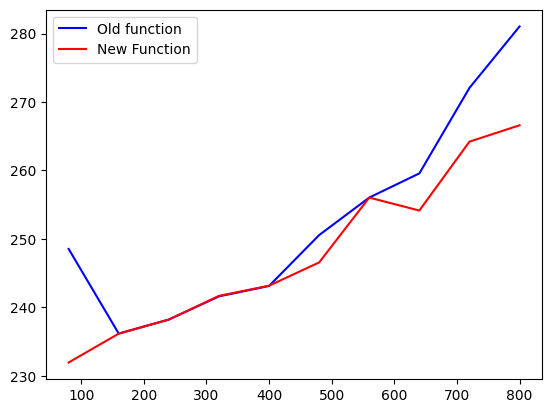

In [5]:
plt.plot(n_structs, mem1, label='Old function', color='blue')
plt.plot(n_structs, mem2, label='New Function', color='red')
plt.legend()

In [4]:
from temp_profiling_funcs import prune_conformers_rmsd, lowmem_prune_conformers_rmsd
from tscode.utils import read_xyz
import numpy as np

data = read_xyz('/mnt/c/Users/Nick/Desktop/Computations/debug/restart2.xyz')
data.atomcoords.shape

(80, 154, 3)

In [5]:

structs = np.concatenate([data.atomcoords for _ in range(10)])
_, mask1 = prune_conformers_rmsd(structs, data.atomnos, 0.25)

Filename: /home/Coding/TSCoDe/tscode/temp_profiling_funcs.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     6    242.6 MiB    242.6 MiB           1   @profile
     7                                         def prune_conformers_rmsd(structures, atomnos, max_rmsd=0.25, max_delta=None, verbose=False):
     8                                             '''
     9                                             Removes similar structures by repeatedly grouping them into k
    10                                             subgroups and removing similar ones. A cache is present to avoid
    11                                             repeating RMSD computations.
    12                                             
    13                                             Similarity occurs for structures with both RMSD < max_rmsd and
    14                                             maximum deviation < max_delta.
    15                                             '''
    16      